In [1]:
import json, torch
from ImageTextData import ImageTextData
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torch import nn
from torch.optim import SGD
from ImageClassificator import ImageClassificator
from BalancedClass import make_weights_for_balanced_classes

In [2]:
with open('./datainfo.json', 'r') as f:
    data = json.load(f)
    

In [3]:
train = ImageTextData(data)
print(len(train))

total_lenght = len(train)
test_lenght = int(total_lenght * .2)   
train_lenght = total_lenght - test_lenght

train_data, test_data = torch.utils.data.random_split(train, [train_lenght, test_lenght]) 


print(f'Calculando pesos de train, tamaño del dataset {len(train_data)}')
weights_train = make_weights_for_balanced_classes(train_data.dataset.targets, train_data.indices, 2)  
weights_train = torch.DoubleTensor(weights_train)      
sampler_train = torch.utils.data.sampler.WeightedRandomSampler(weights_train, len(weights_train))   

print(f'Calculando pesos de test, tamaño del dataset {len(test_data)} ')
weights_test = make_weights_for_balanced_classes(test_data.dataset.targets, test_data.indices, 2)    
weights_test = torch.DoubleTensor(weights_test)      
sampler_test = torch.utils.data.sampler.WeightedRandomSampler(weights_test, len(weights_test))  

print(len(weights_train))
print(len(train_data))

trainloader = torch.utils.data.DataLoader(train_data, sampler = sampler_train, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, sampler = sampler_test, batch_size=32)

51967
Calculando pesos de train, tamaño del dataset 41574
Calculando repeticiones por clase
Repeticiones calculadas, tiempo: 0.009999990463256836
Calculando los pesos por clase
Pasando los pesos para cada imagen
Pesos pasados, tiempo: 0.011998891830444336
Calculando pesos de test, tamaño del dataset 10393 
Calculando repeticiones por clase
Repeticiones calculadas, tiempo: 0.003002643585205078
Calculando los pesos por clase
Pasando los pesos para cada imagen
Pesos pasados, tiempo: 0.0019989013671875
41574
41574


tensor([[0.0078, 0.0157, 0.0157,  ..., 0.0353, 0.0392, 0.0392],
        [0.0196, 0.0157, 0.0196,  ..., 0.0353, 0.0353, 0.0314],
        [0.0157, 0.0196, 0.0196,  ..., 0.0196, 0.0157, 0.0118],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


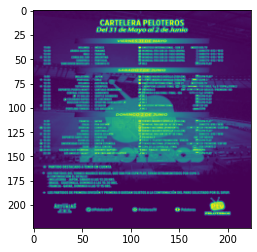

In [4]:

def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.show()

dataiter = iter(trainloader)
data, label = dataiter.next()

print(data[0][0])
imshow(data[0][0])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {device}")

model = ImageClassificator()
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.05)
model.to(device)

device is cuda


ImageClassificator(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
  (soft): Softmax(dim=1)
)

In [6]:

epochs = 2
print_every = 10

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    train_losses, test_losses = [], []
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == 0:    # print every 2000 mini-batches
            
            test_loss = 0
            accuracy = 0
            total = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    predict = model.forward(inputs)
                    batch_loss = criterion(predict, labels)
                    test_loss += batch_loss.item()
                    val, ind = predict.max(1)              
                    accuracy += (ind == labels).sum()
                    total += len(labels)
                    
            
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {running_loss/print_every:.3f}.. "
                f"Test loss: {test_loss/len(testloader):.3f}.. "
                f"Test accuracy: {float(accuracy)/float(total):.3f}")
            running_loss = 0
            accuracy = 0
            total =0
            model.train()


print('Finished Training')

KeyboardInterrupt: 